In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.sparse import random
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import scipy.stats as stats
import seaborn

# NOTE: I am ignoring the max iteration warnings for nmf
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import diffusion_nmf
import importlib
importlib.reload(sparse_nmf)
importlib.reload(diffusion_nmf)
from sparse_nmf import SparseNMF
from diffusion_nmf import DiffusionNMF

### Testing with Synthetic Data

In [2]:
def gen_data():
    # generates testing data and saves it so I can test in matlab as well
    test_h = random(4,100, density = 0.05).A
    H = pd.DataFrame(test_h)

    x = np.linspace(1,10,300)
    y1 = stats.norm.pdf(x, 5) * 20
    y2 = []
    y3 = []
    y4 = []
    for i in x:
        y2.append((i - 5)**2)
        y3.append(2 * i)
        y4.append((i - 5)**3/10 + 10)
    y4 = np.array(y4)

    W = pd.DataFrame(np.array([y1, y2, y3, y4]).T)

    return W,H

In [3]:
W,H = gen_data()
X = np.dot(W,H)

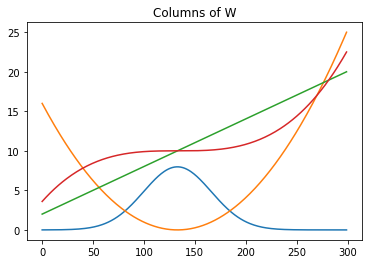

In [4]:
for col in W:
    plt.plot(W.loc[:,col])
    plt.title("Columns of W")

Text(0.5, 1.0, 'Sparse H')

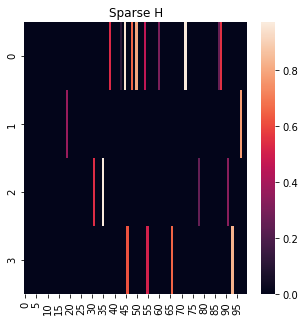

In [5]:
plt.figure(figsize = (5,5))
seaborn.heatmap(H, square = False, cbar = True)
plt.title("Sparse H")

In [6]:
# sparseness of H
h_sparse = 0
for row in H.index:
    rh = np.array(H.loc[row,:])
    sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
    sp /= (math.sqrt(len(rh)) - 1)
    h_sparse += sp
    
h_sparse /= len(H.index)
print(h_sparse)
    

0.8915269441133118


In [7]:
# sparseness of W
w_sparse = 0
for col in W.columns:
    cw = np.array(W.loc[:,col])
    sp = math.sqrt(len(cw)) - (sum(np.abs(cw))/ math.sqrt(sum(cw ** 2)))
    sp /= (math.sqrt(len(cw)) - 1)
    w_sparse += sp
    
w_sparse /= len(W.columns)
print(w_sparse)

0.21078519104020454


### Comparing SparseNMF with Sklearn NMF

In [8]:
model = SparseNMF(X, 4, iterations = 500, sH = h_sparse)    
model.solver()
spW = pd.DataFrame(model.W)
spH = pd.DataFrame(model.H)

Text(0.5, 1.0, 'Original columns of W')

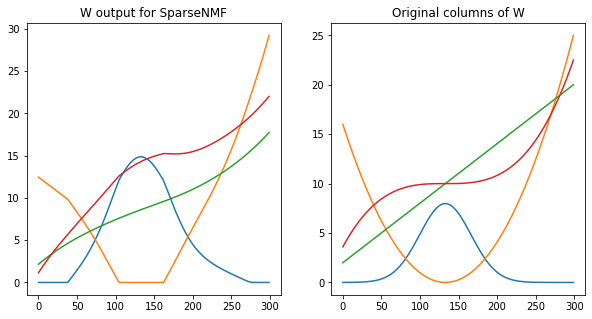

In [9]:
fix, ax = plt.subplots(1, 2, figsize = (10,5))
for col in spW:
    ax[0].plot(spW.loc[:,col])
    ax[1].plot(W.loc[:,col])
    
ax[0].set_title("W output for SparseNMF")
ax[1].set_title("Original columns of W")

Text(0.5, 1.0, 'Original H')

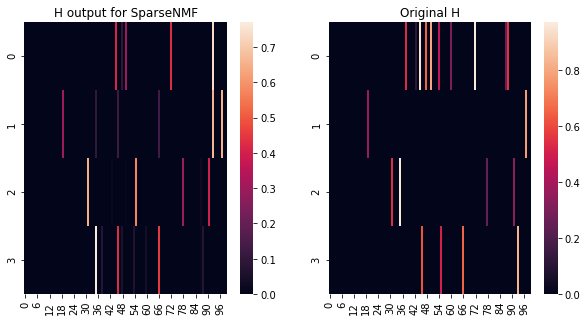

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
seaborn.heatmap(spH, square = False, cbar = True, ax = ax[0])
ax[0].set_title("H output for SparseNMF")
seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Original H")

In [11]:
# ERRors
print("SparseNMF error on W:", np.linalg.norm(W - spW/1.7))
print("SparseNMF error on H:", np.linalg.norm(H - spH))
print("SparseNMF error on X:", np.linalg.norm(X - np.dot(spW, spH)))

SparseNMF error on W: 138.63167144634585
SparseNMF error on H: 2.4638969269695212
SparseNMF error on X: 73.0502486069576


In [12]:
model2 = NMF(n_components = 4, init = 'random', random_state = 35, max_iter = 500)
sciW = pd.DataFrame(model2.fit_transform(X))
sciH = pd.DataFrame(model2.components_)

Text(0.5, 1.0, 'Original columns of W')

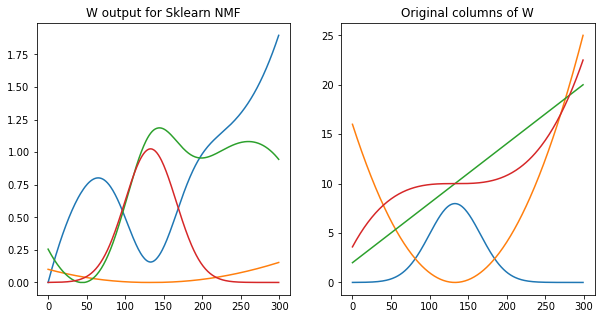

In [13]:
fix, ax = plt.subplots(1, 2, figsize = (10,5))
for col in spW:
    ax[0].plot(sciW.loc[:,col])
    ax[1].plot(W.loc[:,col])
    
ax[0].set_title("W output for Sklearn NMF")
ax[1].set_title("Original columns of W")

Text(0.5, 1.0, 'Original H')

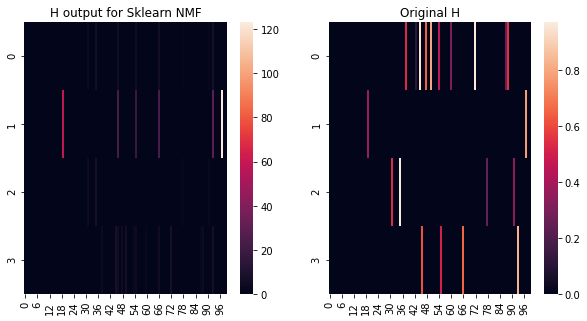

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
seaborn.heatmap(sciH, square = False, cbar = True, ax = ax[0])
ax[0].set_title("H output for Sklearn NMF")
seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Original H")

In [15]:
print("Scipy error on W:", np.linalg.norm(W - sciW))
print("Scipy error on H:", np.linalg.norm(H - sciH))
print("Scipy error on X:", np.linalg.norm(X - np.dot(sciW, sciH)))

Scipy error on W: 330.1176745509215
Scipy error on H: 145.55901373428227
Scipy error on X: 0.13974725463592091


## Diffusion NMF

In [16]:
# Making a synthetic laplacian and corresponding diffusion kernel:
locs = X.shape[1]
lapl = np.zeros((locs,locs))

In [17]:
for i in range(lapl.shape[0]):
    for j in range(lapl.shape[1]):
        if i == j:
            break
        else:
            lapl[i,j] = -1 * np.random.choice([0,1], p = [0.9,0.1])
            lapl[j,i] = lapl[i,j]

In [18]:
for i in range(lapl.shape[0]):
    lapl[i,i] = -1 * lapl[i].sum()

In [19]:
L = lapl
I = np.identity(locs)

In [20]:
beta = 1
Kinv = I + beta * L
K = np.linalg.inv(Kinv)

In [21]:
D = np.dot(W, np.dot(H, K))

In [22]:
differ = DiffusionNMF(D, K, ncomponents = 4, sparseV = h_sparse, sparseX = None, iterations = 500, tol = 1e-10)

In [23]:
differ.solver()
diffX = pd.DataFrame(differ.X)
diffV = pd.DataFrame(differ.V)

Text(0.5, 1.0, 'Original columns of W')

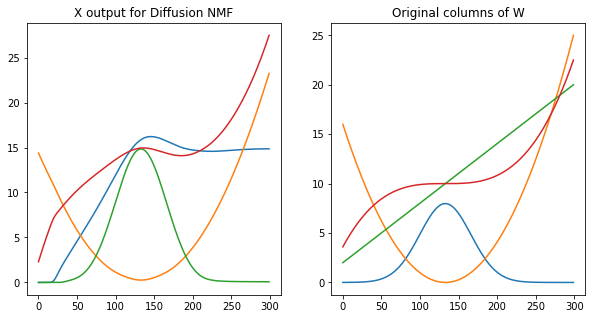

In [24]:
fix, ax = plt.subplots(1, 2, figsize = (10,5))
for col in spW:
    ax[0].plot(diffX.loc[:,col])
    ax[1].plot(W.loc[:,col])
    
ax[0].set_title("X output for Diffusion NMF")
ax[1].set_title("Original columns of W")

Text(0.5, 1.0, 'Original H')

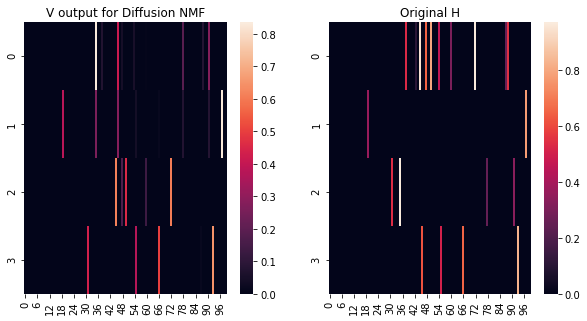

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
seaborn.heatmap(diffV, square = False, cbar = True, ax = ax[0])
ax[0].set_title("V output for Diffusion NMF")
seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Original H")

In [26]:
print("Diffusion X error on W:", np.linalg.norm(W - diffX))
print("Diffusion V error on H:", np.linalg.norm(H - diffV))
print("Diffusion error on D:", np.linalg.norm(D - np.dot(diffX, np.dot(diffV, K))))

Diffusion X error on W: 264.66534559795576
Diffusion V error on H: 2.7956058758172593
Diffusion error on D: 6.103742394043946
